In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

# import sklearn
import warnings
warnings.filterwarnings("ignore")

In [170]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import sum, mean

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)


In [171]:
# read in the taxi data required for following analysis
sdf = spark.read.parquet('../data/aggregated_results3.parquet/')
sdf = sdf.withColumn("count", F.round(col("sum_fare_amount") / col("avg_fare_amount"),0))
sdf = sdf.groupBy("Month", 'dayofmonth').agg(sum("count").alias("trip_num")) \
        .sort("Month", "dayofmonth")
df = sdf.toPandas()
df.tail()

,Month,dayofmonth,trip_num
361,12,27,164974.0
362,12,28,167770.0
363,12,29,160700.0
364,12,30,169930.0
365,12,31,164880.0


In [172]:
# read in the weather data
wdf =  pd.read_csv('../data/weather_p.csv')
wdf = wdf.sort_values(by=['month', 'day'])
wsdf = spark.createDataFrame(wdf).groupBy("month") \
    .agg(mean("TAVG").alias("avg_TAVG"),
        mean("TMAX").alias("avg_TMAX"),
        mean("TMIN").alias("avg_TMIN"),
        mean("PRCP").alias("avg_PRCP"),        
        mean("SNWD").alias("avg_SNWD"),        
        mean("SNOW").alias("avg_SNOW")) \
    .sort("month")
wsdf.limit(12)


month,avg_TAVG,avg_TMAX,avg_TMIN,avg_PRCP,avg_SNWD,avg_SNOW
1,33.193548387096776,39.00584898971997,23.456546142030017,0.1699352098612165,0.04380973196861821,0.04839899468863783
2,35.45238095238095,41.75902668759811,26.69440083725798,0.12304081886770576,0.12683158634556152,0.11932443728764566
3,40.6236559139785,47.27277561148531,30.925203828429638,0.1263464582522557,0.7998967863183187,0.31625546502796076
4,53.54444444444444,62.35256410256411,44.95622710622711,0.16418779970999567,0.0,0.0
5,61.31182795698924,69.56575682382135,53.14374335342077,0.25700192623342455,0.0,0.0
6,71.76666666666667,79.82087912087914,62.13406593406593,0.17797677022109443,0.0,0.0
7,80.03225806451613,87.99539170506912,69.93195084485407,0.2040642125911931,0.0,0.0
8,75.74193548387096,83.29936192839419,66.47791563275436,0.1512569861409304,0.0,0.0
9,70.63333333333331,78.22142857142856,59.659682539682535,0.03778379553152844,0.0,0.0
10,60.15053763440861,66.3908661231242,50.836866359447,0.20588718306841053,0.0,0.0


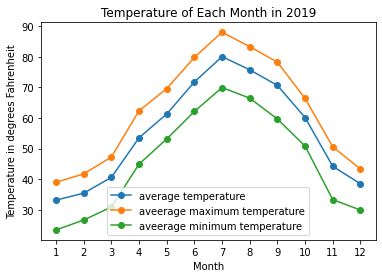

In [173]:
# plot for temperature
data = wsdf.toPandas()
x = data.month
y1 = data['avg_TAVG']
y2 = data['avg_TMAX']
y3 = data['avg_TMIN']
title = "Temperature of Each Month in 2019"
plt.xticks(data.month)
plt.title(title)
plt.ylabel("Temperature in degrees Fahrenheit")
plt.xlabel("Month")
plt.plot(x, y1, label ="average temperature",Marker='o')
plt.plot(x, y2, label ="aveerage maximum temperature",Marker='o')
plt.plot(x, y3, label ="aveerage minimum temperature",Marker='o')
plt.legend()
plt.savefig("../plots/temmp_month.png", bbox_inches = "tight")

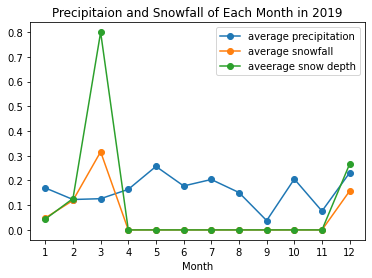

In [174]:
# plot for precipitation and snow fall
y1 = data['avg_PRCP']
y2 = data['avg_SNOW']
y3 = data['avg_SNWD']
title = "Precipitaion and Snowfall of Each Month in 2019"
plt.xticks(data.month)
plt.title(title)
plt.xlabel("Month")
plt.plot(x, y1, label ="average precipitation",Marker='o')
plt.plot(x, y2, label ="average snowfall",Marker='o')
plt.plot(x, y3, label ="aveerage snow depth",Marker='o')
plt.legend()
plt.savefig("../plots/prep_month.png", bbox_inches = "tight")

     Month  dayofmonth  trip_num
59       2          29       7.0
359     12          25   98977.0


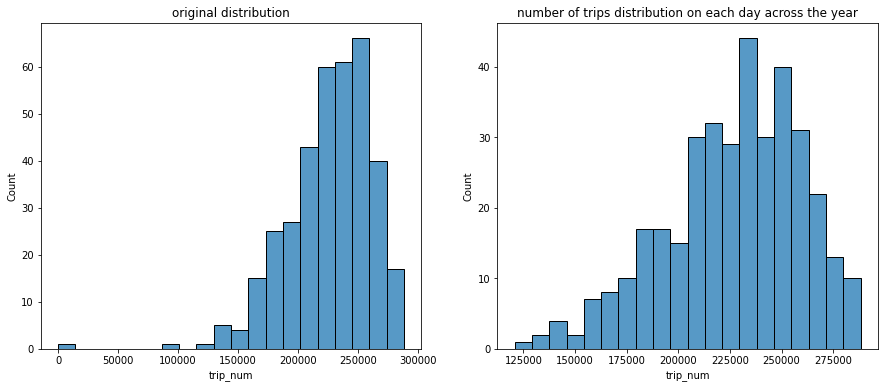

In [175]:
# Identify the outlier by visualisation
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(df['trip_num'],ax=ax1,bins=20) \
    .set_title("original distribution")
outlier = df.loc[df["trip_num"]<100000]
print(outlier)
df = df.loc[df["trip_num"]>=100000]
sns.histplot(df['trip_num'],ax=ax2,bins=20) \
    .set_title("After remove the outliers")
plt.title("number of trips distribution on each day across the year")
plt.savefig("../plots/dayofyear_num_trips.png")

In [176]:
# Join two dataframes by the date
new_df = pd.merge(wdf, df,  how='inner', left_on=['month','day'], right_on = ['Month','dayofmonth'])
new_df = new_df.drop(["Unnamed: 0", "month", "day", "Month", "dayofmonth"], axis=1)
new_df.tail()

,TAVG,TMIN,TMAX,PRCP,SNOW,SNWD,trip_num
359,48.333333,37.538462,49.461538,0.000137,0.0,0.0,164974.0
360,47.666667,36.928571,51.928571,0.000658,0.0,0.0,167770.0
361,41.666667,31.714286,46.142857,0.047922,0.0,0.0,160700.0
362,41.666667,35.357143,43.357143,0.672405,0.0,0.0,169930.0
363,40.000000,37.000000,43.428571,0.395696,0.0,0.0,164880.0


In [177]:
from statsmodels.formula.api import *
fit = ols(formula="trip_num ~ TAVG + TMIN + TMAX + PRCP + SNOW + SNWD",
         data=new_df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               trip_num   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     16.15
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           1.87e-16
Time:                        06:03:04   Log-Likelihood:                -4258.4
No. Observations:                 364   AIC:                             8531.
Df Residuals:                     357   BIC:                             8558.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.671e+05   7466.611     35.774      0.0

In [178]:
fit = ols(formula="trip_num ~ TAVG + TMAX + PRCP + SNOW + SNWD",
         data=new_df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               trip_num   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     18.99
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           9.23e-17
Time:                        06:03:04   Log-Likelihood:                -4259.3
No. Observations:                 364   AIC:                             8531.
Df Residuals:                     358   BIC:                             8554.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.62e+05   6398.690     40.951      0.0

In [179]:
# in a machine learning way
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

reg = LinearRegression()
X = new_df.drop("trip_num", axis=1)
# ones = pd.DataFrame(np.ones(364))
# X.insert(0,"ones",ones)
y = new_df["trip_num"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
reg.fit(x_train,y_train)
y_pred = reg.predict(x_test)
# ref to https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
# The mean squared error
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('Root Mean squared error: ', np.sqrt(mean_squared_error(y_test, y_pred)))
# r2
print('Coefficient of determination:',r2_score(y_test, y_pred))


Mean squared error:  754660516.7123098
Coefficient of determination: 0.217272552664457
